In [2]:
import numpy as np
import pandas as pd
import geopandas as gpd
import statsmodels as sm
from statsmodels.genmod.generalized_linear_model import GLM
import math
from geopy.distance import geodesic
from tqdm import tqdm
import matplotlib.pyplot as plt
from shapely.geometry import Polygon, Point
import folium
import h3
import folium
import copy
import county_tesslation

In [33]:
import gravity_ as gr

In [57]:
import importlib
importlib.reload(gr)

<module 'gravity_' from '/Users/hemingyi/Research/202410_skmob/gravity/gravity_.py'>

# H3 Resolution Setting

In [3]:
is_h3_hexagon = True
hex_resolution = 7

# Relevance Data

## StayCount Info

In [4]:
relevance_df = pd.read_parquet('/Users/hemingyi/Research/202410_skmob/scala_proj/mob_scala/tem_output_12_par_r/6-stays_h3_region.parquet')
# h3_id_region format: decimal to hexadecimal
relevance_df['h3_id_region'] = relevance_df['h3_id_region'].map(lambda x: hex(int(x))[2:])
relevance_df

,caid,h3_region_stay_id,stay_start_timestamp,stay_end_timestamp,stay_duration,h3_id_region,row_count_for_region
0,000124462fb7b671332bd72771fd49d126d7e1055d826a...,0,2019-01-01 01:00:14,2019-01-01 01:00:14,0,8929a40c8d3ffff,1
1,000124462fb7b671332bd72771fd49d126d7e1055d826a...,1,2019-01-05 18:02:09,2019-01-05 18:02:09,0,8929a428623ffff,1
2,000124462fb7b671332bd72771fd49d126d7e1055d826a...,2,2019-01-05 18:57:47,2019-01-05 18:57:47,0,8929a428693ffff,1
3,000124462fb7b671332bd72771fd49d126d7e1055d826a...,3,2019-01-05 19:26:12,2019-01-05 19:26:12,0,8929a40c8d3ffff,1
4,000124462fb7b671332bd72771fd49d126d7e1055d826a...,4,2019-01-11 19:55:48,2019-01-11 19:55:48,0,8929a42b673ffff,1
...,...,...,...,...,...,...,...
94180112,fffdd44510885e222e7dfbc4f308ae200ef6d2dcf8db8c...,36,2019-01-12 21:46:18,2019-01-12 21:46:18,0,892986b9087ffff,1
94180113,fffdd44510885e222e7dfbc4f308ae200ef6d2dcf8db8c...,37,2019-01-12 22:18:12,2019-01-12 22:18:55,43,892986b9543ffff,3
94180114,fffdd44510885e222e7dfbc4f308ae200ef6d2dcf8db8c...,38,2019-01-12 22:26:03,2019-01-12 22:26:03,0,892986b942fffff,1
94180115,fffe5ed3c9854f1f78baac9f60f658dd4900488fc96991...,0,2019-01-05 04:20:19,2019-01-05 04:20:29,10,8929124eb6bffff,2


In [5]:
stayCount_df = gr.obtain_relevance_data_at_resolution(
    relevance_df, 
    colname_h3_index='h3_id_region',
    colname_caid='caid',
    hex_resolution=hex_resolution)
stayCount_df

,index,stay_count,geometry
0,870c14666ffffff,1,"POLYGON ((64.52197 -165.46328, 64.51056 -165.4..."
1,870c42c01ffffff,3,"POLYGON ((60.14067 -149.43773, 60.13183 -149.4..."
2,870c42c05ffffff,1,"POLYGON ((60.16023 -149.42660, 60.15140 -149.4..."
3,870c42c2bffffff,1,"POLYGON ((60.13496 -149.36766, 60.12614 -149.3..."
4,870c51cc0ffffff,1,"POLYGON ((59.65959 -151.50764, 59.65050 -151.5..."
...,...,...,...
88481,875d16b63ffffff,2,"POLYGON ((20.75491 -156.34568, 20.74186 -156.3..."
88482,875d16b65ffffff,1,"POLYGON ((20.79403 -156.33240, 20.78099 -156.3..."
88483,875d16b6cffffff,1,"POLYGON ((20.76417 -156.30278, 20.75112 -156.3..."
88484,875d16b6dffffff,1,"POLYGON ((20.75729 -156.27860, 20.74425 -156.2..."


## Population Info

In [6]:
state_fips_codes=['06']
county_fips_codes={'06': ['001']}
#county_fips_code={'06': ['001', '013', '041', '055', '075', '081', '085', '095', '097']} # Bay Area
year=2020
census_dataset='acs/acs5'
projection_crs='EPSG:3310'
census_variables=['NAME', 'B01003_001E']

In [7]:
pop_df = gr.obtain_population_data(
    state_fips_codes, 
    county_fips_codes, 
    hex_resolution, 
    year,
    census_dataset, 
    projection_crs, 
    census_variables)
pop_df

,index,geometry,Hexagon Population
0,872830802ffffff,"POLYGON ((-122.31282 37.79273, -122.30530 37.8...",758.985504
1,872830803ffffff,"POLYGON ((-122.33797 37.80204, -122.33045 37.8...",2.979472
2,872830806ffffff,"POLYGON ((-122.31152 37.77041, -122.30401 37.7...",1476.979635
3,872830810ffffff,"POLYGON ((-122.26382 37.79642, -122.25629 37.8...",29596.097275
4,872830811ffffff,"POLYGON ((-122.28897 37.80574, -122.28144 37.8...",8329.553729
...,...,...,...
373,872836b6effffff,"POLYGON ((-121.68086 37.49044, -121.67326 37.5...",125.863471
374,872836b70ffffff,"POLYGON ((-121.58154 37.47478, -121.57393 37.4...",52.280754
375,872836b71ffffff,"POLYGON ((-121.60666 37.48431, -121.59905 37.4...",79.308014
376,872836b72ffffff,"POLYGON ((-121.55756 37.48768, -121.54994 37.4...",79.340645


# Fitting Data

In [8]:
# actual_flow_df
actual_flow_df_path = 'trips'
name_caid = 'caid'
name_origin = 'origin'
name_destination = 'destination'
name_distance = 'distance'

In [ ]:
afdf = pd.read_parquet(actual_flow_df_path)
print(afdf.shape)
afdf.head()

(46237600, 4)


,caid,origin,destination,distance
0,00010baadaed40c9fbf9701ea443708cc1ee38b12a98a8...,8929a110a6fffff,8929a186ac3ffff,42.971812
1,00010baadaed40c9fbf9701ea443708cc1ee38b12a98a8...,8929a186ac3ffff,8929a1873abffff,7.815188
2,00010baadaed40c9fbf9701ea443708cc1ee38b12a98a8...,8929a1873abffff,8929a110a6fffff,38.607961
3,00010baadaed40c9fbf9701ea443708cc1ee38b12a98a8...,8929a110a6fffff,8929a110b4fffff,1.672450
4,00010baadaed40c9fbf9701ea443708cc1ee38b12a98a8...,8929a110b4fffff,8929a110a6fffff,1.672450


In [9]:
flow_hex_df = gr.get_actual_flow_hex_df(
    actual_flow_df_path,  
    name_caid, 
    name_origin, 
    name_destination, 
    name_distance,
    hex_resolution,
    pop_df, # filtering accoridng to pop_df range
    )
flow_hex_df

,origin,destination,flow,distance
0,872830802ffffff,872830803ffffff,101,0.917417
1,872830802ffffff,872830806ffffff,7,0.924918
2,872830802ffffff,872830810ffffff,267,2.296542
3,872830802ffffff,872830811ffffff,383,1.670262
4,872830802ffffff,872830812ffffff,20,5.263865
...,...,...,...,...
24106,872836b59ffffff,872834683ffffff,1,14.619383
24107,872836b59ffffff,8728346ecffffff,1,38.262819
24108,872836b59ffffff,872836a66ffffff,1,3.383375
24109,872836b59ffffff,872836a69ffffff,1,12.815249


In [10]:
valid_indices = set(pop_df['index'])

stayCount_df_sel = stayCount_df[
    stayCount_df['index'].isin(valid_indices)
]
stayCount_df_sel = stayCount_df_sel.reset_index(drop=True)

In [11]:
print(stayCount_df_sel.shape)
stayCount_df_sel.head()

(342, 3)


,index,stay_count,geometry
0,872830802ffffff,6612,"POLYGON ((37.79273 -122.31282, 37.80451 -122.3..."
1,872830803ffffff,1572,"POLYGON ((37.80204 -122.33797, 37.81381 -122.3..."
2,872830806ffffff,282,"POLYGON ((37.77041 -122.31152, 37.78219 -122.3..."
3,872830810ffffff,113346,"POLYGON ((37.79642 -122.26382, 37.80820 -122.2..."
4,872830811ffffff,26417,"POLYGON ((37.80574 -122.28897, 37.81751 -122.2..."


# Visualization

In [161]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Polygon, Point, LineString
from h3 import h3
import matplotlib.pyplot as plt
import contextily as ctx

def h3_to_polygon(h3_index):
    """
    Convert an H3 index into a shapely Polygon (in lon, lat order).
    """
    boundary = h3.h3_to_geo_boundary(h3_index, True)
    polygon_coords = [(coord[1], coord[0]) for coord in boundary]
    return Polygon(polygon_coords)

def h3_to_point(h3_index):
    """
    Convert an H3 index into a shapely Point of its center (in lon, lat).
    """
    lat, lon = h3.h3_to_geo(h3_index)
    return Point(lon, lat)

def plot_flow_map(flow_df, flow_col='flow', origin_col='origin', destination_col='destination', 
                  figsize=(10, 10), linewidth_scale=0.001, picFileName='flow_map.png'):

    all_h3 = pd.concat([flow_df[origin_col], flow_df[destination_col]]).unique()

    hex_gdf = gpd.GeoDataFrame({
        'h3_index': all_h3,
    }, geometry=[h3_to_polygon(x) for x in all_h3], crs='EPSG:4326')

    # Build a GeoDataFrame for the flow lines
    # For each row in flow_df, create a LineString between the origin and destination points
    lines = []
    for _, row in flow_df.iterrows():
        origin_point = h3_to_point(row[origin_col])
        destination_point = h3_to_point(row[destination_col])
        line = LineString([origin_point, destination_point])
        lines.append((line, row[flow_col]))
        
    line_gdf = gpd.GeoDataFrame(flow_df.copy(), 
                                geometry=[l[0] for l in lines], 
                                crs='EPSG:4326')
    
    # Reproject to Web Mercator for contextily
    hex_gdf_3857 = hex_gdf.to_crs(epsg=3857)
    line_gdf_3857 = line_gdf.to_crs(epsg=3857)

    fig, ax = plt.subplots(figsize=figsize)
    hex_gdf_3857.plot(ax=ax, alpha=0.5, edgecolor='black', facecolor='gray')

    # Determine line widths based on flow values
    max_flow = line_gdf_3857[flow_col].max()
    med_flow = line_gdf_3857[flow_col].median()
    if max_flow == 0:
        max_flow = 1
    linewidths = linewidth_scale * (line_gdf_3857[flow_col]) # / med_flow)

    line_gdf_3857.plot(ax=ax, color='red', linewidth=linewidths)
    ctx.add_basemap(ax, source=ctx.providers.OpenStreetMap.Mapnik)
    ax.set_axis_off()

    plt.savefig(picFileName, format='png', dpi=300, bbox_inches='tight')
    plt.show()
    plt.close(fig)


# Setting

In [214]:
name = 'Example Gravity Model'
flow_data = flow_hex_df

gravity_type = 'single' #'single' 'global'
deterrence_func_type = 'power_law' #'power_law' 'exponential' 
relevance = 'pop' #'stay' 'pop'


if relevance == 'stay':
    relevance_df = stayCount_df_sel
    relevance_column = 'stay_count'
elif relevance == 'pop':
    relevance_df = pop_df #stayCount_df_sel, 
    relevance_column = 'Hexagon Population' # 'stay_count'

linewidth_scale = 1 #0.0001


Generating...


100%|██████████| 378/378 [00:05<00:00, 71.02it/s] 
/Users/hemingyi/Research/202410_skmob/gravity/gravity_.py:121: RuntimeWarning: divide by zero encountered in power
  self.deterrence_function = lambda d: d ** exponent


Plotting...


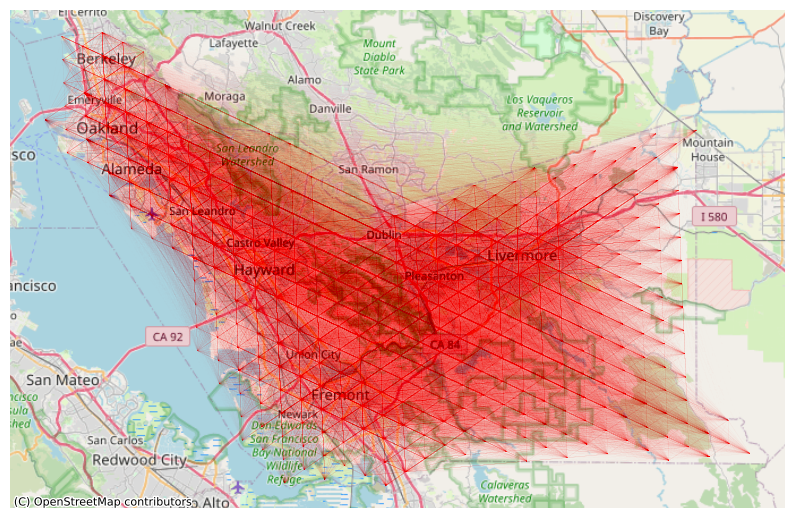

,origin,destination,flow
0,872830802ffffff,872830803ffffff,0.000035
1,872830802ffffff,872830806ffffff,0.016694
2,872830802ffffff,872830810ffffff,0.109436
3,872830802ffffff,872830811ffffff,0.089097
4,872830802ffffff,872830812ffffff,0.055374
...,...,...,...
142501,872836b73ffffff,872836b6dffffff,0.000973
142502,872836b73ffffff,872836b6effffff,0.001618
142503,872836b73ffffff,872836b70ffffff,0.008223
142504,872836b73ffffff,872836b71ffffff,0.011827


In [ ]:
# Fitting
# fit the parameters of the Gravity model from real fluxes

gravity_fitted = gr.Gravity(
    name="Gravity model", 
    deterrence_func_type = deterrence_func_type, 
    deterrence_func_args=[-2.0], 
    origin_exp=1.0, 
    destination_exp=1.0, 
    gravity_type = gravity_type, 
    is_h3_hexagon=is_h3_hexagon
    )
print(gravity_fitted)

gravity_fitted.fit(
    flow_data, 
    relevance_df, 
    relevance_column,
    )
print(gravity_fitted)


# Generating
print('Generating...')
gravity_model_gen = gr.Gravity(
    deterrence_func_type=deterrence_func_type,
    deterrence_func_args=gravity_fitted.get_str("deterrence_func_args")[0],
    origin_exp=gravity_fitted.get_str("origin_exp")[0],
    destination_exp=gravity_fitted.get_str("destination_exp")[0],
    gravity_type=gravity_type,
    name=name,
    is_h3_hexagon=is_h3_hexagon
)
'''

# Generating - No fitting
print('Generating...')
gravity_model_gen = gr.Gravity(
    deterrence_func_type=deterrence_func_type,
    deterrence_func_args=[-2.0],
    origin_exp=1.0,
    destination_exp=1.0,
    gravity_type=gravity_type,
    name=name,
    is_h3_hexagon=is_h3_hexagon
)
'''

np.random.seed(0)
flow_df = gravity_model_gen.generate(
    spatial_tessellation = relevance_df,
    tile_id_column='index',
    relevance_column = relevance_column,
    #tot_outflows_column='total_outflow',
    out_format='probabilities' # ‘flow', 
)

flow_df.to_csv(f'generative_flow_{relevance}_{gravity_type}_{deterrence_func_type}.csv')

print('Plotting...')

if gravity_type == 'global':
    linewidth_scale_mul = linewidth_scale * len(flow_df['origin'].unique())
elif gravity_type == 'single':
    linewidth_scale_mul = linewidth_scale

picFileName = f'flowMap_{relevance}_{gravity_type}_{deterrence_func_type}.png'

plot_flow_map(flow_df,linewidth_scale=linewidth_scale_mul,picFileName=picFileName)

flow_df